In [2]:
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

torch.manual_seed(1) #reproducible
EPOCH = 4
BATCH_SIZE = 128

train_data = torchvision.datasets.MNIST(
    root='./mnist', #保存位置
    train=True, #training set
    transform=torchvision.transforms.ToTensor(), #converts a PIL.Image to torch.FloatTensor(C*H*W) in range(0.0,1.0)
    download=True
)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_data = torchvision.datasets.MNIST(
    root='./MNIST',
    train=False,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE,shuffle=False)

In [1]:
def train(learning_rate,u0,idx):
    torch.manual_seed(27)
    # network structure
    class CNN(nn.Module):
        def __init__(self,D_in,H,D_out):
            super(CNN, self).__init__()
            self.fc1 = nn.Linear(D_in,H)
            torch.nn.init.normal(self.fc1.weight, mean=0, std=0.03)
            #nn.init.xavier_normal(self.fc1.weight,gain = 1)
            nn.init.constant(self.fc1.bias, 0.1)
        
            self.fc2 = nn.Linear(H,D_out)
            torch.nn.init.normal(self.fc2.weight, mean=0, std=0.3)
            #nn.init.xavier_normal(self.fc2.weight, gain = 1)
            nn.init.constant(self.fc2.bias, 0.1)
           # self.out = nn.Linear(10,10)
        
        def forward(self, x):
            x = x.view(-1, 784)
            x = F.relu(self.fc1(x))
            x = F.softmax(self.fc2(x))
            output = x
            #output = self.out(x)
            return output

    D_in,H,D_out = 784,10,10
    cnn = CNN(D_in,H,D_out)

    # initial hyperpaameter
    #loss function:cross-entropy with l2 regularizaiton
    loss_func = nn.CrossEntropyLoss()
    # inital all using viariables
    EMAg = []
    EMAg_2 = []
    EMAx = []
    EMAx_2 = []
    EMAxg = []
    EMAu = []
    beta = []

    # training iteration
    for epoch in range(EPOCH):
        running_loss = 0.0                        # loss to show
        #training each mini-batch in dataloader
        for i, data in enumerate(train_loader,0):
           # get the inputs
            inputs, labels = data

            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            cnn.zero_grad()

            # forward + backward
            outputs = cnn(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
       
            # implementation of cSGD algo
            for index,params in enumerate(cnn.parameters(),0):
            
                #update parameters process
                if(i==0 and epoch==0):
                    #lists store EMA of weight_grad, weight_grad_square, weight, and weight_square
                
                    EMAg.append(torch.Tensor(params.size()))
                    EMAx.append(torch.Tensor(params.size()))
                    EMAx_2.append(torch.Tensor(params.size()))
                    EMAg_2.append(torch.Tensor(params.size()))
                    EMAxg.append(torch.Tensor(params.size()))
                
                    n = params.dim()
                    if n ==1:
                        for item in range(0,params.size()[0]):
                            EMAg[index][item] = params.grad.data[item]
                            EMAx[index][item] = params.data[item]
                            EMAg_2[index][item] = params.grad.data[item]**2
                            EMAx_2[index][item] = params.data[item]**2
                            EMAxg[index][item] = params.data[item]*params.grad.data[item]**2
                    
                    if n ==2:
                    
                        for item1 in range(0,params.size()[0]):
                            for item2 in range(0,params.size()[1]):
                                EMAg[index][item1,item2] = params.grad.data[item1,item2]
                                EMAx[index][item1,item2] = params.data[item1,item2]
                                EMAg_2[index][item1,item2] = params.grad.data[item1,item2]**2
                                EMAx_2[index][item1,item2] = params.data[item1,item2]**2
                                EMAxg[index][item1,item2] = params.data[item1,item2]*params.grad.data[item1,item2]
                
                    #lists store EMA of u and beta
                    EMAu.append(torch.Tensor(params.size()))
                    beta.append(torch.ones(params.size())*0.9)
                    EMAu[index] = torch.ones(EMAu[index].size())*u0
                    #print(EMAg[index][0,64])
                    #print(EMAg_2[index][0,1])
                else:
                    one = torch.ones(params.size())
                    #print(EMAg_2[index][0,1])
                    #update EMA
                    EMAg[index] = (beta[index])*EMAg[index]+(one-beta[index])*params.grad.data
                    EMAg_2[index] = (beta[index])*EMAg_2[index] + (one-beta[index])*(params.grad.data.pow(2))
                    EMAx[index] = (beta[index])*EMAx[index] + (one-beta[index])*params.data
                    EMAx_2[index] = (beta[index])*EMAx_2[index]+(one-beta[index])*(params.data.pow(2))
                    EMAxg[index] = (beta[index])*EMAxg[index] + (one-beta[index])*(params.grad.data*params.data)
                
                    #print(params.grad.data[0,64])
                
                    #cal a,b,sigma,u*
                    n = params.dim()
                    a = torch.Tensor(params.size())
                    b = torch.Tensor(params.size())
                    sigma = torch.Tensor(params.size())
                    u = torch.Tensor(params.size())
            
            
                    if n == 1:
                        for item in range(0,params.size()[0]):
                            #cal a
                            if EMAxg[index][item]==EMAg[index][item]*EMAx[index][item]:
                                 a[item] = 0
                            elif (EMAx_2[index][item]-EMAx[index][item]**2)==0:
                                 a[item] = 0
                            else:
                                 a[item] = (EMAxg[index][item]-EMAg[index][item]*EMAx[index][item])/(EMAx_2[index][item]-EMAx[index][item]**2)
                        
                        
                            #cal sigma
                            sigma[item] = EMAg_2[index][item] - EMAg[index][item]**2
                        
                            #cal u*
                            if(a[item]<= 0):
                                u[item] = 1
                            else:
                                if(EMAg[index][item]==0):
                                    u[item] = 0.0
                                elif(sigma[item]==0 or a[item]==0):
                                    u[item] = 1.0
                                else:
                                    u[item] = min(1,(EMAg[index][item]**2)/(learning_rate*sigma[item]*a[item])) 
                            #update EMA u
                            EMAu[index][item] = (1-beta[index][item])*EMAu[index][item] + beta[index][item]*u[item]
                    
                            #cal beta
                            if (EMAg_2[index][item]==EMAg[index][item]**2):
                                beta[index][item] = 0.9
                            elif (EMAg_2[index][item]==0):
                                beta[index][item] = 0.9
                            else:
                                beta[index][item] = 0.9+(0.999-0.9)*(EMAg_2[index][item]-EMAg[index][item]**2)/(EMAg_2[index][item])
                        
                    if n == 2:
                    
                        for item1 in range(0,params.size()[0]):
                            for item2 in range(0,params.size()[1]):
                                #cal a
                                if ((EMAxg[index][item1,item2]-EMAg[index][item1,item2]*EMAx[index][item1,item2])==0):
                                    a[item1,item2] = 0
                                elif (EMAx_2[index][item1,item2]-EMAx[index][item1,item2]**2)==0:
                                    a[item1,item2] = 0
                                else:
                                    a[item1,item2] =(EMAxg[index][item1,item2]-EMAg[index][item1,item2]*EMAx[index][item1,item2])/(EMAx_2[index][item1,item2]-EMAx[index][item1,item2]**2)            
                                    #print(a[item1,item2])
                        
                                #cal sigma
                                sigma[item1,item2] = EMAg_2[index][item1,item2] - math.pow(EMAg[index][item1,item2],2)
                                #print(sigma[item1,item2])
                                #if sigma[item1,item2]<0 :
                                #    print("%d %d %d"%(i,item1,item2))
                                #    print(EMAg_2[index][item1,item2],EMAg[index][item1,item2])
                                #cal u*
                                if(a[item1,item2]<= 0):
                                    u[item1,item2] = 1.0
                                else:
                                    if(EMAg[index][item1,item2]==0):
                                        u[item1,item2] = 0.0
                                    elif(sigma[item1,item2]==0 or a[item1,item2]==0):
                                        u[item1,item2] = 1.0
                                    else:
                                        u[item1,item2] = min(1,(EMAg[index][item1,item2]**2)/(learning_rate*sigma[item1,item2]*a[item1,item2])) 
                                        #print(sigma[item1,item2]*a[item1,item2],EMAg[index][item1,item2]**2)
                                        #print(EMAg[index][item1,item2]**2)
                                        #print(a[item1,item2]*((EMAx[index][item1,item2]-b[item1,item2])**2)/(learning_rate*sigma[item1,item2]))
                                #update EMAu
                                EMAu[index][item1,item2] = (1-beta[index][item1,item2])*EMAu[index][item1,item2] + (beta[index][item1,item2])*u[item1,item2]
                                #print(params.grad.data[5,5],params.data[5,5])
                                #print(EMAx[index][0,5],EMAg[index][0,5],EMAu[index][0,5])
                            
                                #if i>=100:
                                #    print(EMAu[index][item1,item2])
                                #cal beta
                                if EMAg_2[index][item1,item2]==EMAg[index][item1,item2]**2:
                                    beta[index][item1,item2] = 0.9
                                elif (EMAg_2[index][item1,item2]==0):
                                    beta[index][item1,item2] = 0.9
                                else:
                                    beta[index][item1,item2] = 0.9+(0.999-0.9)*(EMAg_2[index][item1,item2]-EMAg[index][item1,item2]**2)/(EMAg_2[index][item1,item2])
                        #print(params.grad.data[5,5],params.data[5,5],EMAu[index][5,5])
                        #print(EMAx[index][5,5],EMAg[index][5,5],EMAu[index][5,5])
                #update weight and bias
            
                params.data -= learning_rate *EMAu[index]* params.grad.data
        
            #print("%d %d"%(epoch, i))
            running_loss += loss.data[0]
            if i % 100 == 0:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.8f' %(epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
                correct = 0.0
                total = 0.0
                for data in test_loader:
                    images, labels = data
                    outputs = cnn(Variable(images))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum()
                    #result_data[idx][i/100+epoch*4] = correct/total
                result_data1[idx][int(i/100)+epoch*5] = correct/total
    print('Finished Training')
    correct = 0.0
    total = 0.0
    for data in test_loader:
        images, labels = data
        outputs = cnn(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    print('lr:%f u0:%f Accuracy: %f' % (learning_rate,u0,(correct / total)))

In [16]:
np.random.seed(8)

#random_u0 = -2*np.random.random(20)
#random_lr = -1*np.random.random(20)
x_u0 = [0.2,0.01]
#x_u0 = np.sort(10**random_u0)
x_lr = [0.2,0.6]
result_data = np.zeros((len(x_u0),20))
result_data1 = np.zeros((len(x_u0),20))
#x_lr = np.sort(10**random_lr)
#x = [0.002,0.04,0.3]
for index in range(0, len(x_u0)):
    lr = x_lr[index]
    u0 = x_u0[index]
    #beta_w1 = 1/(784*10)
    #beta_w2 = 1/(10*10)
    #beta_b = 1/(10)
    train(lr,u0,index)

[1,   100] loss: 2.36821994
[1,   200] loss: 2.36285792
[1,   300] loss: 2.33817821
[1,   400] loss: 2.32242626
[2,   100] loss: 2.26988127
[2,   200] loss: 2.25620906
[2,   300] loss: 2.24440068
[2,   400] loss: 2.19782070
[3,   100] loss: 2.12975661
[3,   200] loss: 2.11873385
[3,   300] loss: 2.10838831
[3,   400] loss: 2.10146113


KeyboardInterrupt: 

In [12]:
result_9_1 = np.zeros(16)
result_9_1 = result_data1[0,:]
result_9_1

array([ 0.387 ,  0.7292,  0.8143,  0.8291,  0.835 ,  0.8409,  0.8442,
        0.84  ,  0.8469,  0.8489,  0.849 ,  0.8512,  0.852 ,  0.8512,
        0.8527,  0.8518])

In [ ]:
result1 = result_data
import numpy as np
import matplotlib.pyplot as plt

Xmax = np.zeros(43)
Xmin = np.zeros(43)
X_lrmax = np.zeros(43)
X_lrmin = np.zeros(43)
X_lrmedian = np.zeros(43)
Xlr = y
Xsum = np.zeros(30)

# find max and min each test step to get area of accuracy distribution
for n in range(0,43):
    Xmax[n] = np.max(result_data[:,n])
    Xmin[n] = np.min(result_data[:,n])

# calculate area-under-curve and save it to Xsum
for m in range(0,30):   
    Xsum[m]  = np.sum(result_data[m,:])

# find index of learning rate refer to max and min auc 
lr_min_i = np.argwhere(Xsum == np.min(Xsum))
lr_max_i = np.argwhere(Xsum == np.max(Xsum))

lr_min = Xlr[lr_min_i[0,0]]
lr_max = Xlr[lr_max_i[0,0]]


for n in range(0,43):
    X_lrmin[n] = result_data[lr_min_i[0,0],n]
    X_lrmax[n] = result_data[lr_max_i[0,0],n]

In [ ]:
import matplotlib 
from matplotlib.ticker import  MultipleLocator
matplotlib.use('Agg')
x_index=np.arange(0,4,4.0/43)
X_lrmedian = result_data[13,:]
fig = plt.figure()
plt.title("cSGD")
plt.xlabel('Epoch')
plt.ylabel('Test Accu')
plt.axis([0,4,0.0,1.0]) 
plt.plot(x_index,X_lrmedian,color = 'red',label='1e-2')
plt.plot(x_index,X_lrmin,'r--',label='1e-3')
plt.plot(x_index,X_lrmax,'r-.',label='2e-1')
plt.fill_between(x_index,Xmin,Xmax,color = 'red',alpha = '0.1')
plt.legend(loc='lower right',framealpha = 0.5)
plt.savefig("cSGD new.png") 
plt.show()



In [ ]:
import pandas as pd
import numpy as np

adagrad_result_csv = pd.DataFrame(np.zeros((30,43)))
adagrad_result_csv.iloc[:,:] = result_data
adagrad_result_csv.to_csv('cSGD',index=False)
training_csv = pd.read_csv('cSGD',index_col=0)
training_csv

np.save('cSGD-np.npy',result_data)

In [ ]:
import matplotlib 
from matplotlib.ticker import  MultipleLocator
matplotlib.use('Agg')
x_index=np.arange(0,4,4.0/43)
X1 = result_data1[0,:]
X2 = result_data1[1,:]
X3 = result_data1[2,:]
fig = plt.figure()
plt.title("cSGD")
plt.xlabel('Epoch')
plt.ylabel('Test Accu')
plt.axis([0,4,0.0,1.0]) 
plt.plot(x_index,X1,'r--',label='2e-3')
plt.plot(x_index,X2,color = 'red',label='4e-2')
plt.plot(x_index,X3,'r-.',label='3e-1')
plt.fill_between(x_index,X1,X3,color = 'red',alpha = '0.1')
plt.legend(loc='lower right',framealpha = 0.5)
plt.savefig("cSGD para.png") 
plt.show()

/Users/apple/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


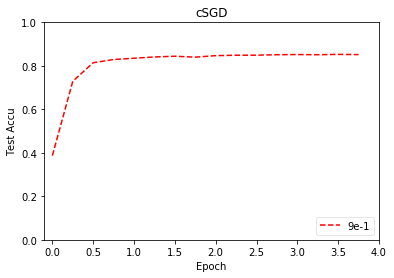

In [15]:
import matplotlib 
from matplotlib.ticker import  MultipleLocator
matplotlib.use('Agg')
x_index=np.arange(0,4,4.0/16)
X1 = result_9_1
#X2 = result_data1[1,:]
#X3 = result_data1[2,:]
fig = plt.figure()
plt.title("cSGD")
plt.xlabel('Epoch')
plt.ylabel('Test Accu')
plt.axis([-0.1,4,0.0,1.0]) 
plt.plot(x_index,X1,'r--',label='9e-1')
#plt.plot(x_index,X2,color = 'red',label='4e-2')
#plt.plot(x_index,X3,'r-.',label='3e-1')
#plt.fill_between(x_index,X1,X3,color = 'red',alpha = '0.1')
plt.legend(loc='lower right',framealpha = 0.5)
#plt.savefig("cSGD para.png") 
plt.show()